In [1]:
import os
from dotenv import load_dotenv
from copernicusmarine import login

load_dotenv()

CMDS_USERNAME = os.getenv("CMDS_USERNAME")
CMDS_PASSWORD = os.getenv("CMDS_PASSWORD")

if not CMDS_USERNAME or not CMDS_PASSWORD:
    raise ValueError("CMDS_USERNAME or CMDS_PASSWORD not set in .env")

# Authenticate with Copernicus Marine
login(username=CMDS_USERNAME, password=CMDS_PASSWORD)

File /home/diana-bacircea/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

ERROR - 2025-07-24T10:52:13Z - Abort
INFO - 2025-07-24T10:52:13Z - No configuration file have been modified.


False

In [2]:
from copernicusmarine import subset
import os

def download_cmems_data(experiment, type, minimum_longitude, maximum_longitude,
                            minimum_latitude, maximum_latitude,
                            start_datetime, end_datetime):

    # Product info
    if type == "currents":
        dataset_id = "cmems_mod_glo_phy_anfc_0.083deg_PT1H-m"
        variables = ["uo", "vo"]
    elif type == "winds":
        dataset_id = "cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H"
        variables = ["eastward_wind", "northward_wind"]

    # Output filename
    os.makedirs("data", exist_ok=True)

    output_filename = f"data/{experiment}_{type}_{start_datetime[:10]}_{end_datetime[:10]}.nc"

    if os.path.exists(output_filename):
        print(f"File {output_filename} already exists. Skipping download.")
        return

    subset(
        dataset_id=dataset_id,
        variables=variables,
        minimum_longitude=minimum_longitude,
        maximum_longitude=maximum_longitude,
        minimum_latitude=minimum_latitude,
        maximum_latitude=maximum_latitude,
        start_datetime=start_datetime,
        end_datetime=end_datetime,
        output_filename=output_filename,
    )

    print(f"Download complete: {output_filename}")

## Ross Sea Nurdle Spill Experiment 

In [3]:
CMEMS_MIN_LAT = -78.0
CMEMS_MAX_LAT = -70.0
CMEMS_MIN_LON = 162.0       
CMEMS_MAX_LON = 220.0
SPILL_POINT_LAT = -72.97
SPILL_POINT_LON = 171.54
EXPERIMENT = 'ross_sea_nurdle_spill'
START_DATETIME = "2024-12-01T00:00:00Z"
END_DATETIME = "2025-01-31T23:59:59Z"

In [4]:
download_cmems_data(
    experiment=EXPERIMENT,
    type="currents",
    minimum_longitude=CMEMS_MIN_LON,
    maximum_longitude=CMEMS_MAX_LON,
    minimum_latitude=CMEMS_MIN_LAT,
    maximum_latitude=CMEMS_MAX_LAT,
    start_datetime=START_DATETIME,
    end_datetime=END_DATETIME
)

File data/ross_sea_nurdle_spill_currents_2024-12-01_2025-01-31.nc already exists. Skipping download.


In [5]:
download_cmems_data(
    experiment="ross_sea_nurdle_spill",
    type="winds",
    minimum_longitude=CMEMS_MIN_LON,
    maximum_longitude=CMEMS_MAX_LON,
    minimum_latitude=CMEMS_MIN_LAT,
    maximum_latitude=CMEMS_MAX_LAT,
    start_datetime="2024-12-01T00:00:00Z",
    end_datetime="2025-01-31T23:59:59Z"
)

File data/ross_sea_nurdle_spill_winds_2024-12-01_2025-01-31.nc already exists. Skipping download.


In [6]:
import os
import numpy as np
from datetime import datetime
from opendrift.readers import reader_netCDF_CF_generic, reader_global_landmask
from opendrift.models.oceandrift import OceanDrift


PARTICLES_NUMBER = int(os.getenv("PARTICLES_NUMBER"))

print(f"Spill point: ({SPILL_POINT_LAT}, {SPILL_POINT_LON})")
print(f"Number of particles: {PARTICLES_NUMBER}")


# Load Copernicus data
reader_currents = reader_netCDF_CF_generic.Reader('data/ross_sea_nurdle_spill_currents_2024-12-01_2025-01-31.nc')
reader_winds = reader_netCDF_CF_generic.Reader('data/ross_sea_nurdle_spill_winds_2024-12-01_2025-01-31.nc')
reader_ice = reader_netCDF_CF_generic.Reader('data/ross_sea_nurdle_spill_ice_2024-12-01_2025-01-31.nc')

# Initialize model
o = OceanDrift(loglevel=20)
o1 = OceanDrift(loglevel=20)
o.add_reader([reader_currents, reader_winds, reader_ice, reader_global_landmask.Reader()])
o1.add_reader([reader_currents, reader_global_landmask.Reader()])

# --- Model Configuration (Nurdle-Like Behavior) ---
o.set_config('general:coastline_action', 'stranding')  # beaching
o.set_config('drift:vertical_mixing', False)  # No vertical mixing

o1.set_config('general:coastline_action', 'stranding')  # beaching
o1.set_config('drift:vertical_mixing', False)  # No vertical mixing


radius_lat = 0.045  
radius_lon = 0.174

seed_lons = np.random.normal(loc=SPILL_POINT_LON, scale=radius_lon, size=PARTICLES_NUMBER)
seed_lats = np.random.normal(loc=SPILL_POINT_LAT, scale=radius_lat, size=PARTICLES_NUMBER)

# Seed particles
o.seed_elements(
    lon=seed_lons,
    lat=seed_lats,
    time=datetime(2024, 12, 1),
)

o1.seed_elements(
    lon=seed_lons,
    lat=seed_lats,
    time=datetime(2024, 12, 1),
)

# Run simulation through January 2025
o.run(
    end_time=datetime(2025, 1, 31),
    time_step=3600,
    time_step_output=86400
)

o1.run(
    end_time=datetime(2025, 1, 31),
    time_step=3600,
    time_step_output=86400
)


Spill point: (-72.97, 171.54)
Number of particles: 50000


10:52:17 INFO    opendrift:513: OpenDriftSimulation initialised (version 1.14.2 / v1.14.2-82-g86a40e4)
10:52:17 INFO    opendrift:513: OpenDriftSimulation initialised (version 1.14.2 / v1.14.2-82-g86a40e4)
10:52:19 INFO    opendrift.models.basemodel.environment:229: Fallback values will be used for the following variables which have no readers: 
10:52:19 INFO    opendrift.models.basemodel.environment:232: 	sea_surface_height: 0.000000
10:52:19 INFO    opendrift.models.basemodel.environment:232: 	upward_sea_water_velocity: 0.000000
10:52:19 INFO    opendrift.models.basemodel.environment:232: 	ocean_vertical_diffusivity: 0.000000
10:52:19 INFO    opendrift.models.basemodel.environment:232: 	sea_surface_wave_significant_height: 0.000000
10:52:19 INFO    opendrift.models.basemodel.environment:232: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
10:52:19 INFO    opendrift.models.basemodel.environment:232: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
10:52:19 INFO    opendrift.mod

<xarray.Dataset> Size: 261MB
Dimensions:                                   (trajectory: 50000, time: 62)
Coordinates:
  * trajectory                                (trajectory) int64 400kB 0 ... ...
  * time                                      (time) datetime64[ns] 496B 2024...
Data variables: (12/21)
    status                                    (trajectory, time) float32 12MB ...
    moving                                    (trajectory, time) float32 12MB ...
    age_seconds                               (trajectory, time) float32 12MB ...
    origin_marker                             (trajectory, time) float32 12MB ...
    lon                                       (trajectory, time) float32 12MB ...
    lat                                       (trajectory, time) float32 12MB ...
    ...                                        ...
    upward_sea_water_velocity                 (trajectory, time) float32 12MB ...
    sea_surface_wave_significant_height       (trajectory, time) float32 12MB ...
    sea_surface_wave_stokes_drift_x_velocity  (trajectory, time) float32 12MB ...
    sea_surface_wave_stokes_drift_y_velocity  (trajectory, time) float32 12MB ...
    sea_floor_depth_below_sea_level           (trajectory, time) float32 12MB ...
    land_binary_mask                          (trajectory, time) float32 12MB ...
Attributes: (12/117)
    Conventions:                                                           CF...
    standard_name_vocabulary:                                              CF...
    featureType:                                                           tr...
    title:                                                                 Op...
    summary:                                                               Ou...
    keywords:                                                              tr...
    ...                                                                    ...
    geospatial_lon_units:                                                  de...
    geospatial_lon_resolution:                                             point
    runtime:                                                               1:...
    geospatial_vertical_min:                                               0.0
    geospatial_vertical_max:                                               0.0
    geospatial_vertical_positive:                                          up

In [7]:
print(o)

--------------------
Reader performance:
--------------------
data/ross_sea_nurdle_spill_currents_2024-12-01_2025-01-31.nc
 0:00:24.2  total
 0:00:01.7  preparing
 0:00:21.7  reading
 0:00:09.9  interpolation
 0:00:00.0  interpolation_time
 0:00:00.6  masking
--------------------
data/ross_sea_nurdle_spill_winds_2024-12-01_2025-01-31.nc
 0:00:09.5  total
 0:00:00.8  preparing
 0:00:08.0  reading
 0:00:04.6  interpolation
 0:00:00.0  interpolation_time
 0:00:00.4  masking
--------------------
global_landmask
 0:00:03.4  total
 0:00:00.2  preparing
 0:00:03.0  reading
 0:00:00.0  masking
--------------------
Performance:
 1:42.2 total time
    2.3 configuration
    0.0 preparing main loop
      0.0 moving elements to ocean
 1:39.8 main loop
     36.8 updating elements
    0.0 cleaning up
--------------------
Model:	OceanDrift     (OpenDrift version 1.14.2)
	50000 active Lagrangian3DArray particles  (0 deactivated, 0 scheduled)
-------------------
Environment variables:
  -----
  x_sea_wa

In [8]:
print(o1)

--------------------
Reader performance:
--------------------
data/ross_sea_nurdle_spill_currents_2024-12-01_2025-01-31.nc
 0:00:24.2  total
 0:00:01.7  preparing
 0:00:21.7  reading
 0:00:09.9  interpolation
 0:00:00.0  interpolation_time
 0:00:00.6  masking
--------------------
global_landmask
 0:00:04.1  total
 0:00:00.2  preparing
 0:00:03.8  reading
 0:00:00.0  masking
--------------------
Performance:
1:06:51.9 total time
 1:42.3 configuration
    0.0 preparing main loop
      0.0 moving elements to ocean
1:05:09.5 main loop
     18.4 updating elements
    0.0 cleaning up
--------------------
Model:	OceanDrift     (OpenDrift version 1.14.2)
	44108 active Lagrangian3DArray particles  (5892 deactivated, 0 scheduled)
-------------------
Environment variables:
  -----
  x_sea_water_velocity
  y_sea_water_velocity
     1) data/ross_sea_nurdle_spill_currents_2024-12-01_2025-01-31.nc
  -----
  land_binary_mask
     1) global_landmask
  -----
Readers not added for the following variables

In [9]:
filename = f"{EXPERIMENT}_{START_DATETIME[:10]}_{END_DATETIME[:10]}"

12:00:15 WARNING py.warnings:110: /home/diana-bacircea/miniconda3/envs/opendrift/lib/python3.13/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)

12:00:15 WARNING py.warnings:110: /home/diana-bacircea/miniconda3/envs/opendrift/lib/python3.13/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)

12:00:15 WARNING py.warnings:110: /home/diana-bacircea/miniconda3/envs/opendrift/lib/python3.13/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, np.intc(handle_nan), out=out, **kwargs)

12:00:15 WARNING py.warnings:110: /home/diana-bacircea/miniconda3/envs/opendrift/lib/python3.13/site-packages/shapely/creation.py:218: RuntimeWarning: invalid value encountered in linestrings
  return l

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2024-12-01 00:00 to 2025-01-31 00:00 UTC (62 steps)'}>,
 <Figure size 1100x983.332 with 1 Axes>)

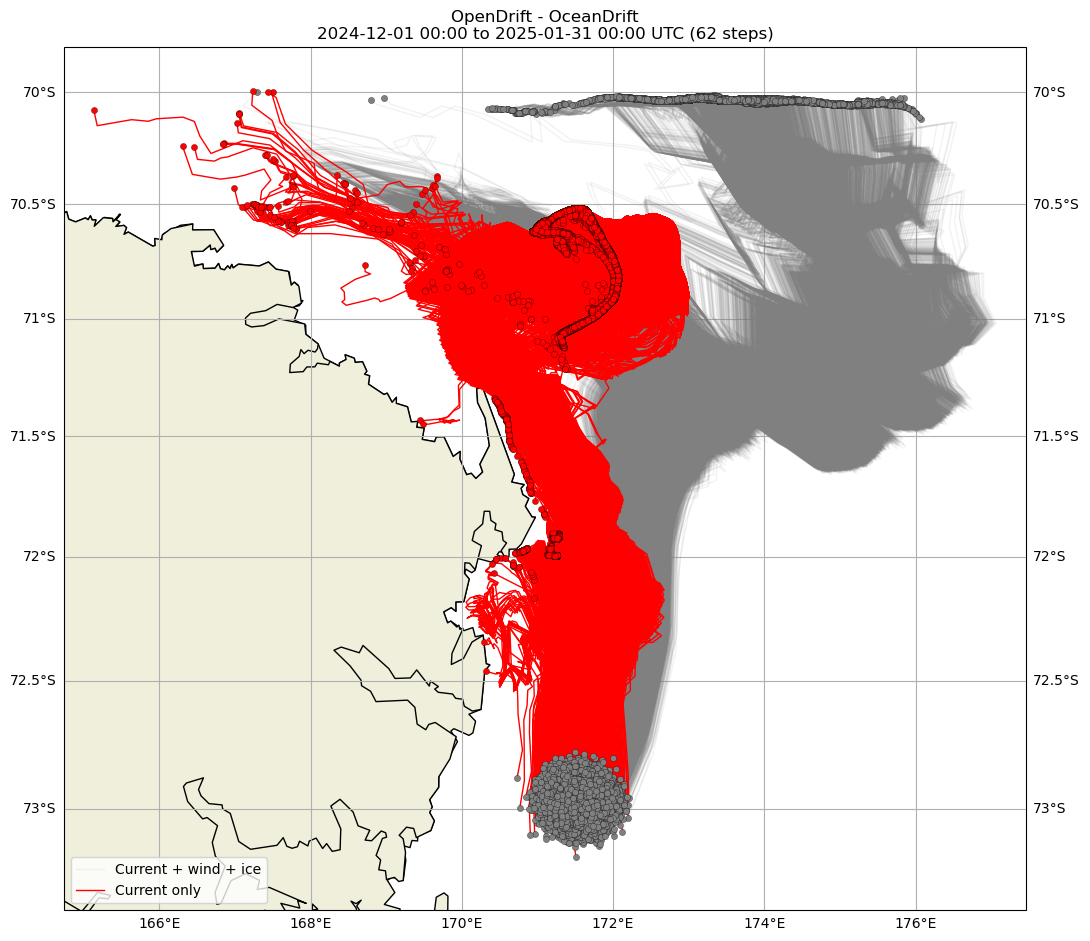

In [10]:
from datetime import datetime

# Get current system time
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M%S")

os.makedirs("simulations", exist_ok=True)

# Use it in the filename
o.plot(
    compare=o1,
    fast=False,
    legend=['Current + wind + ice', 'Current only'],
    filename=f"simulations/{filename}_{timestamp_str}.png",
    show_grid=True,
    lonlat_grid=True,
    grid_labels=True,
    coastline=True,
)

In [11]:
# New OpenDrift-compatible way
final_lons = o.result.lon[-1]
final_lats = o.result.lat[-1]

# Bounding box
min_lon = np.min(final_lons)
max_lon = np.max(final_lons)
min_lat = np.min(final_lats)
max_lat = np.max(final_lats)

print("Bounding box of active particles (final positions):")
print(f"Longitude: {min_lon:.4f} to {max_lon:.4f}")
print(f"Latitude:  {min_lat:.4f} to {max_lat:.4f}")


Bounding box of active particles (final positions):
Longitude: 169.6436 to 175.3744
Latitude:  -73.0278 to -70.0317


In [12]:
from datetime import datetime

# Get current system time
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M%S")

os.makedirs("simulations", exist_ok=True)

filename = f"simulations/{filename}_{timestamp_str}.mp4"

o.animation(
    compare=o1,
    fast=False,
    legend=['Current + wind + ice', 'Current only'],
    filename=filename,
    show_elements=True,
    show_trajectory=True,
    marker_size=2,
    dpi=150,
    show_grid=True,
    lonlat_grid=True,
    grid_labels=True,
    grid_minor=True,
    linewidth=0.5,
)

12:03:42 INFO    opendrift:4533: Saving animation to simulations/ross_sea_nurdle_spill_2024-12-01_2025-01-31_20250724_150342.mp4...
12:04:21 INFO    opendrift:2974: Time to make animation: 0:00:38.717116


## Real Case: Galicia Nurdle Spill Experiment

In [13]:
CMEMS_MIN_LAT = 30.0    # Near Madeira, Canary Current region
CMEMS_MAX_LAT = 52.0    # Covers southern English Channel
CMEMS_MIN_LON = -25.0   # Farther west into the deep Atlantic
CMEMS_MAX_LON = 5.0     # Includes western Mediterranean (Gulf of Lion, Balearic Sea)

SPILL_POINT_LAT = 41.97    # Exact latitude of the Toconao container spill
SPILL_POINT_LON = -8.97    # Exact longitude of the spill location

EXPERIMENT = 'galicia_toconao_nurdle_spill'
START_DATETIME = "2022-12-08T00:00:00Z"
END_DATETIME = "2023-02-08T23:59:59Z"

In [14]:
download_cmems_data(
    experiment=EXPERIMENT,
    type="currents",
    minimum_longitude=CMEMS_MIN_LON,
    maximum_longitude=CMEMS_MAX_LON,
    minimum_latitude=CMEMS_MIN_LAT,
    maximum_latitude=CMEMS_MAX_LAT,
    start_datetime=START_DATETIME,
    end_datetime=END_DATETIME
)

File data/galicia_toconao_nurdle_spill_currents_2022-12-08_2023-02-08.nc already exists. Skipping download.


In [15]:
download_cmems_data(
    experiment=EXPERIMENT,
    type="winds",
    minimum_longitude=CMEMS_MIN_LON,
    maximum_longitude=CMEMS_MAX_LON,
    minimum_latitude=CMEMS_MIN_LAT,
    maximum_latitude=CMEMS_MAX_LAT,
    start_datetime=START_DATETIME,
    end_datetime=END_DATETIME
)

File data/galicia_toconao_nurdle_spill_winds_2022-12-08_2023-02-08.nc already exists. Skipping download.


In [16]:
import os
import numpy as np
from datetime import datetime
from opendrift.readers import reader_netCDF_CF_generic, reader_global_landmask
from opendrift.models.oceandrift import OceanDrift


PARTICLES_NUMBER = int(os.getenv("PARTICLES_NUMBER"))

print(f"Spill point: ({SPILL_POINT_LAT}, {SPILL_POINT_LON})")
print(f"Number of particles: {PARTICLES_NUMBER}")


# Load Copernicus data
reader_currents = reader_netCDF_CF_generic.Reader('data/galicia_toconao_nurdle_spill_currents_2022-12-08_2023-02-08.nc')
reader_winds = reader_netCDF_CF_generic.Reader('data/galicia_toconao_nurdle_spill_winds_2022-12-08_2023-02-08.nc')


# Initialize model
o = OceanDrift(loglevel=20)
o.add_reader([reader_currents, reader_winds, reader_global_landmask.Reader()])

# --- Model Configuration (Nurdle-Like Behavior) ---
o.set_config('general:coastline_action', 'stranding')  # beaching


radius_lat = 0.045  
radius_lon = 0.174

seed_lons = np.random.normal(loc=SPILL_POINT_LON, scale=radius_lon, size=PARTICLES_NUMBER)
seed_lats = np.random.normal(loc=SPILL_POINT_LAT, scale=radius_lat, size=PARTICLES_NUMBER)

# Seed particles
o.seed_elements(
    lon=seed_lons,
    lat=seed_lats,
    time=datetime(2022, 12, 8),
)

# Run simulation through February 2023
o.run(
    end_time=datetime(2023, 2, 8),
    time_step=3600,
    time_step_output=86400
)

12:04:21 INFO    opendrift.readers:61: Opening file with xr.open_dataset
12:04:21 INFO    opendrift.readers.reader_netCDF_CF_generic:299: Grid coordinates are detected, but proj4 string not given: assuming latlong
12:04:21 INFO    opendrift.readers.reader_netCDF_CF_generic:332: Detected dimensions: {'z': 'depth', 'y': 'latitude', 'x': 'longitude', 'time': 'time'}
12:04:21 INFO    opendrift.readers.basereader:176: Variable x_sea_water_velocity will be rotated from eastward_sea_water_velocity
12:04:21 INFO    opendrift.readers.basereader:176: Variable y_sea_water_velocity will be rotated from northward_sea_water_velocity
12:04:21 INFO    opendrift.readers:61: Opening file with xr.open_dataset
12:04:21 INFO    opendrift.readers.reader_netCDF_CF_generic:299: Grid coordinates are detected, but proj4 string not given: assuming latlong
12:04:21 INFO    opendrift.readers.reader_netCDF_CF_generic:332: Detected dimensions: {'y': 'latitude', 'x': 'longitude', 'time': 'time'}
12:04:21 INFO    open

Spill point: (41.97, -8.97)
Number of particles: 50000


12:04:21 INFO    opendrift:2015: 2022-12-08 01:00:00 - step 2 of 1488 - 50000 active elements (0 deactivated)
12:04:22 INFO    opendrift:2015: 2022-12-08 02:00:00 - step 3 of 1488 - 44457 active elements (5543 deactivated)
12:04:23 INFO    opendrift:2015: 2022-12-08 03:00:00 - step 4 of 1488 - 44193 active elements (5807 deactivated)
12:04:23 INFO    opendrift:2015: 2022-12-08 04:00:00 - step 5 of 1488 - 44192 active elements (5808 deactivated)
12:04:23 INFO    opendrift:2015: 2022-12-08 05:00:00 - step 6 of 1488 - 43323 active elements (6677 deactivated)
12:04:23 INFO    opendrift:2015: 2022-12-08 06:00:00 - step 7 of 1488 - 43323 active elements (6677 deactivated)
12:04:23 INFO    opendrift:2015: 2022-12-08 07:00:00 - step 8 of 1488 - 43323 active elements (6677 deactivated)
12:04:23 INFO    opendrift:2015: 2022-12-08 08:00:00 - step 9 of 1488 - 43323 active elements (6677 deactivated)
12:04:23 INFO    opendrift:2015: 2022-12-08 09:00:00 - step 10 of 1488 - 43323 active elements (667

<xarray.Dataset> Size: 265MB
Dimensions:                                   (trajectory: 50000, time: 63)
Coordinates:
  * trajectory                                (trajectory) int64 400kB 0 ... ...
  * time                                      (time) datetime64[ns] 504B 2022...
Data variables: (12/21)
    status                                    (trajectory, time) float32 13MB ...
    moving                                    (trajectory, time) float32 13MB ...
    age_seconds                               (trajectory, time) float32 13MB ...
    origin_marker                             (trajectory, time) float32 13MB ...
    lon                                       (trajectory, time) float32 13MB ...
    lat                                       (trajectory, time) float32 13MB ...
    ...                                        ...
    upward_sea_water_velocity                 (trajectory, time) float32 13MB ...
    sea_surface_wave_significant_height       (trajectory, time) float32 13MB ...
    sea_surface_wave_stokes_drift_x_velocity  (trajectory, time) float32 13MB ...
    sea_surface_wave_stokes_drift_y_velocity  (trajectory, time) float32 13MB ...
    sea_floor_depth_below_sea_level           (trajectory, time) float32 13MB ...
    land_binary_mask                          (trajectory, time) float32 13MB ...
Attributes: (12/117)
    Conventions:                                                           CF...
    standard_name_vocabulary:                                              CF...
    featureType:                                                           tr...
    title:                                                                 Op...
    summary:                                                               Ou...
    keywords:                                                              tr...
    ...                                                                    ...
    geospatial_lon_units:                                                  de...
    geospatial_lon_resolution:                                             point
    runtime:                                                               0:...
    geospatial_vertical_min:                                               0.0
    geospatial_vertical_max:                                               0.0
    geospatial_vertical_positive:                                          up

In [17]:
print(o)

--------------------
Reader performance:
--------------------
data/galicia_toconao_nurdle_spill_currents_2022-12-08_2023-02-08.nc
 0:00:06.9  total
 0:00:00.3  preparing
 0:00:06.5  reading
 0:00:01.6  interpolation
 0:00:00.0  interpolation_time
 0:00:00.0  masking
--------------------
data/galicia_toconao_nurdle_spill_winds_2022-12-08_2023-02-08.nc
 0:00:04.8  total
 0:00:00.3  preparing
 0:00:04.4  reading
 0:00:01.6  interpolation
 0:00:00.0  interpolation_time
 0:00:00.0  masking
--------------------
global_landmask
 0:00:01.3  total
 0:00:00.0  preparing
 0:00:01.1  reading
 0:00:00.0  masking
--------------------
Performance:
   51.0 total time
    0.0 configuration
    0.0 preparing main loop
      0.0 moving elements to ocean
   50.8 main loop
     12.0 updating elements
    0.0 cleaning up
--------------------
Model:	OceanDrift     (OpenDrift version 1.14.2)
	11510 active Lagrangian3DArray particles  (38490 deactivated, 0 scheduled)
-------------------
Environment variables:


In [18]:
filename = f"{EXPERIMENT}_{START_DATETIME[:10]}_{END_DATETIME[:10]}"

12:06:20 INFO    opendrift:3667: Time to make plot: 0:01:07.513713


(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2022-12-08 00:00 to 2023-02-08 00:00 UTC (63 steps)'}>,
 <Figure size 1100x759.905 with 1 Axes>)

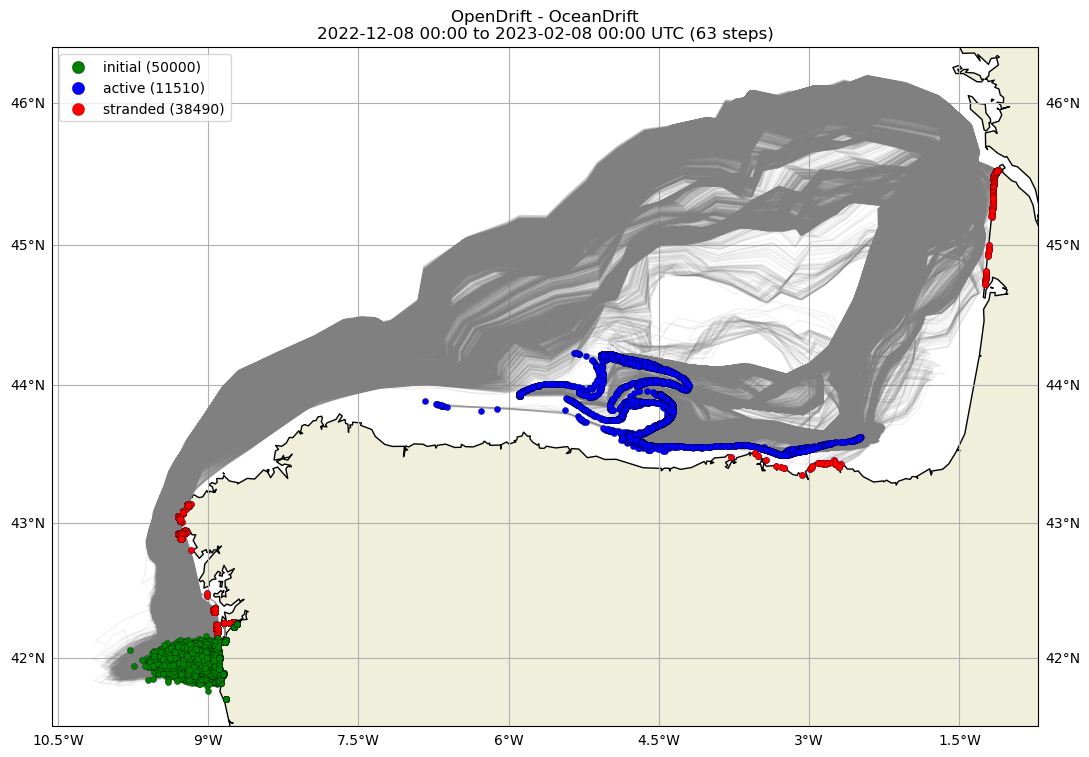

In [19]:
from datetime import datetime

# Get current system time
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M%S")

os.makedirs("simulations", exist_ok=True)

# Use it in the filename
o.plot(
    fast=False,
    legend=True,
    filename=f"simulations/{filename}_{timestamp_str}.png",
    show_grid=True,
    lonlat_grid=True,
    grid_labels=True,
    coastline=True,
)

In [20]:
# New OpenDrift-compatible way
final_lons = o.result.lon[-1]
final_lats = o.result.lat[-1]

# Bounding box
min_lon = np.min(final_lons)
max_lon = np.max(final_lons)
min_lat = np.min(final_lats)
max_lat = np.max(final_lats)

print("Bounding box of active particles (final positions):")
print(f"Longitude: {min_lon:.4f} to {max_lon:.4f}")
print(f"Latitude:  {min_lat:.4f} to {max_lat:.4f}")

Bounding box of active particles (final positions):
Longitude: -9.5968 to -1.3797
Latitude:  41.9001 to 46.1743


In [21]:
from datetime import datetime

# Get current system time
now = datetime.now()
timestamp_str = now.strftime("%Y%m%d_%H%M%S")

os.makedirs("simulations", exist_ok=True)

filename = f"simulations/{filename}_{timestamp_str}.mp4"

o.animation(
    filename=filename,
    show_elements=True,
    show_trajectory=True,
    marker_size=2,
    dpi=150,
    fast=False,
    show_grid=True,
    lonlat_grid=True,
    grid_labels=True,
    grid_minor=True,
    linewidth=0.5,
)

12:06:35 INFO    opendrift:4533: Saving animation to simulations/galicia_toconao_nurdle_spill_2022-12-08_2023-02-08_20250724_150635.mp4...
12:07:01 INFO    opendrift:2974: Time to make animation: 0:00:26.367492
